In [1]:
import anndata
import pyliger
import numpy as np
from scipy import sparse

/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature


In [2]:
# Load AnnData objects
raw_data = anndata.read_h5ad("./data/adata.h5ad.gz")
print(f"Data loaded (Raw): {raw_data.shape} cells x genes")
HVG_data = anndata.read_h5ad("./data/HVG_data.h5ad.gz")
print(f"Data loaded (Filtered + HVG): {HVG_data.shape} cells x genes")
pcHVG_data = anndata.read_h5ad("./data/pcHVG_data.h5ad.gz")
print(f"Data loaded (Filtered + HVG + ZScore): {pcHVG_data.shape} cells x genes")

Data loaded (Raw): (10328, 32738) cells x genes
Data loaded (Filtered + HVG): (10101, 919) cells x genes
Data loaded (Filtered + HVG + ZScore): (10101, 919) cells x genes


In [ ]:
# Integrative non-negative matrix factorization on the normalized and scaled datasets
# Los datos pueden estar limpios, con los genes seleccionados y normalizado pero no centrados.

In [3]:
def create_anndata_by_experiment(anndata_obj, experiment: str): 
    return anndata_obj[anndata_obj.obs.cell_state==experiment, :]

def check_index_name(anndata_obj): 
    if not anndata_obj.obs.index.name: 
        anndata_obj.obs.index.name = "cell_id"
    if not anndata_obj.var.index.name:
        anndata_obj.var.index.name = "gene_name"
    return anndata_obj
    
def check_cell_names(anndata_obj):
    if len(anndata_obj.obs_names)!=anndata_obj.shape[0]:
        print("Missing obs_names in Anndata object")
    elif anndata_obj.obs_names.duplicated().any():
        print("Duplicated obs_names in Anndata object")
    
def check_gene_names(anndata_obj):
    if len(anndata_obj.var_names)!=anndata_obj.shape[1]:
        print("Missing var_names in Anndata object")
    elif anndata_obj.var_names.duplicated().any():
        print("Duplicated var_names in Anndata object")

In [4]:
exp_1_name = "somatic"
exp_2_name = "intermediate plastic state with a regeneration-like program"

# One AnnData object/experiment
exp_1_data = create_anndata_by_experiment(raw_data,exp_1_name)
exp_2_data = create_anndata_by_experiment(raw_data,exp_1_name)

# Create "sample_name" (experiment) in uns 
exp_1_data.uns["sample_name"] = exp_1_name
exp_2_data.uns["sample_name"] = exp_2_name

# Check/create index name
exp_1_data = check_index_name(exp_1_data)
exp_2_data = check_index_name(exp_2_data)

# Check cells/genes names
check_cell_names(exp_1_data)
check_gene_names(exp_1_data)

check_cell_names(exp_2_data)
check_gene_names(exp_2_data)

adata_list = [exp_1_data,exp_2_data]

/tmp/ipykernel_981856/2374759561.py:9: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/tmp/ipykernel_981856/2374759561.py:10: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [6]:
# Create liger obj
# remove_missing=False -> Whether to remove cells not expressing any measured genes, and genes not
# expressed in any cells (if take_gene_union=True, removes only genes not expressed in any dataset)
ifnb_liger = pyliger.create_liger(adata_list)

# Preprocessing and Normalization
pyliger.normalize(ifnb_liger)
pyliger.select_genes(ifnb_liger)
pyliger.scale_not_center(ifnb_liger)

# Joint Matrix Factorization
# K es el número de matrices, análogo a PCA -> recomiendan entre 20-40, lo pongo como el PCA de Scanpy
pyliger.optimize_ALS(ifnb_liger, k=50)

# Quantile Normalization and Joint Clustering
pyliger.quantile_norm(ifnb_liger, knn_k=20, quantiles =50, min_cells=20, max_sample=1000)
pyliger.louvain_cluster(ifnb_liger, resolution = 1)
# pyliger.leiden_cluster(ifnb_liger, resolution=0.25)

# Visualization and Downstream Analysis
pyliger.run_umap(ifnb_liger, distance = 'cosine', n_neighbors = 30, min_dist = 0.3)

100%|██████████| 30/30 [01:43<00:00,  3.45s/it]
/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/pyliger/plotting/_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


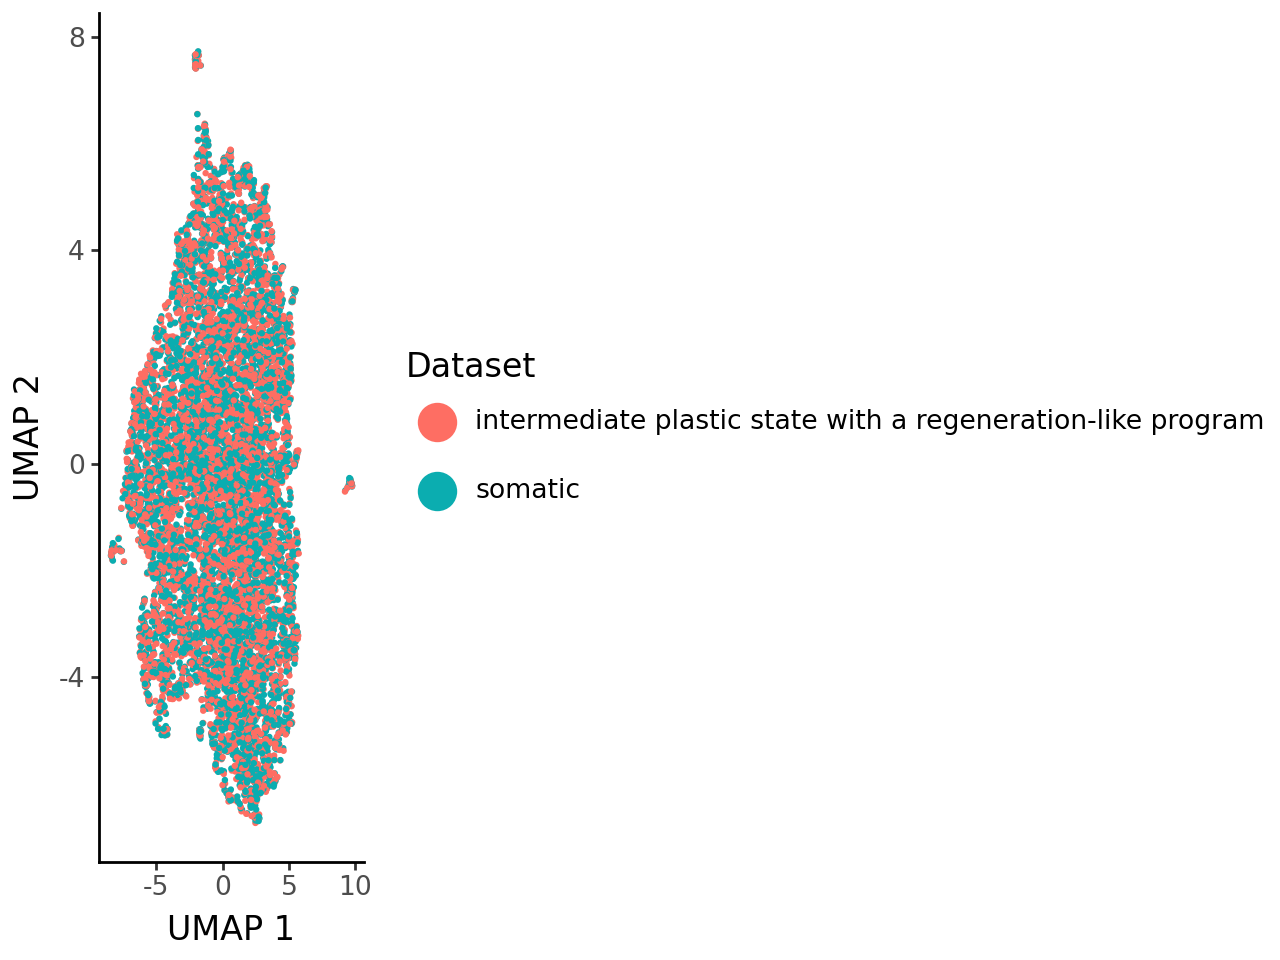

/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


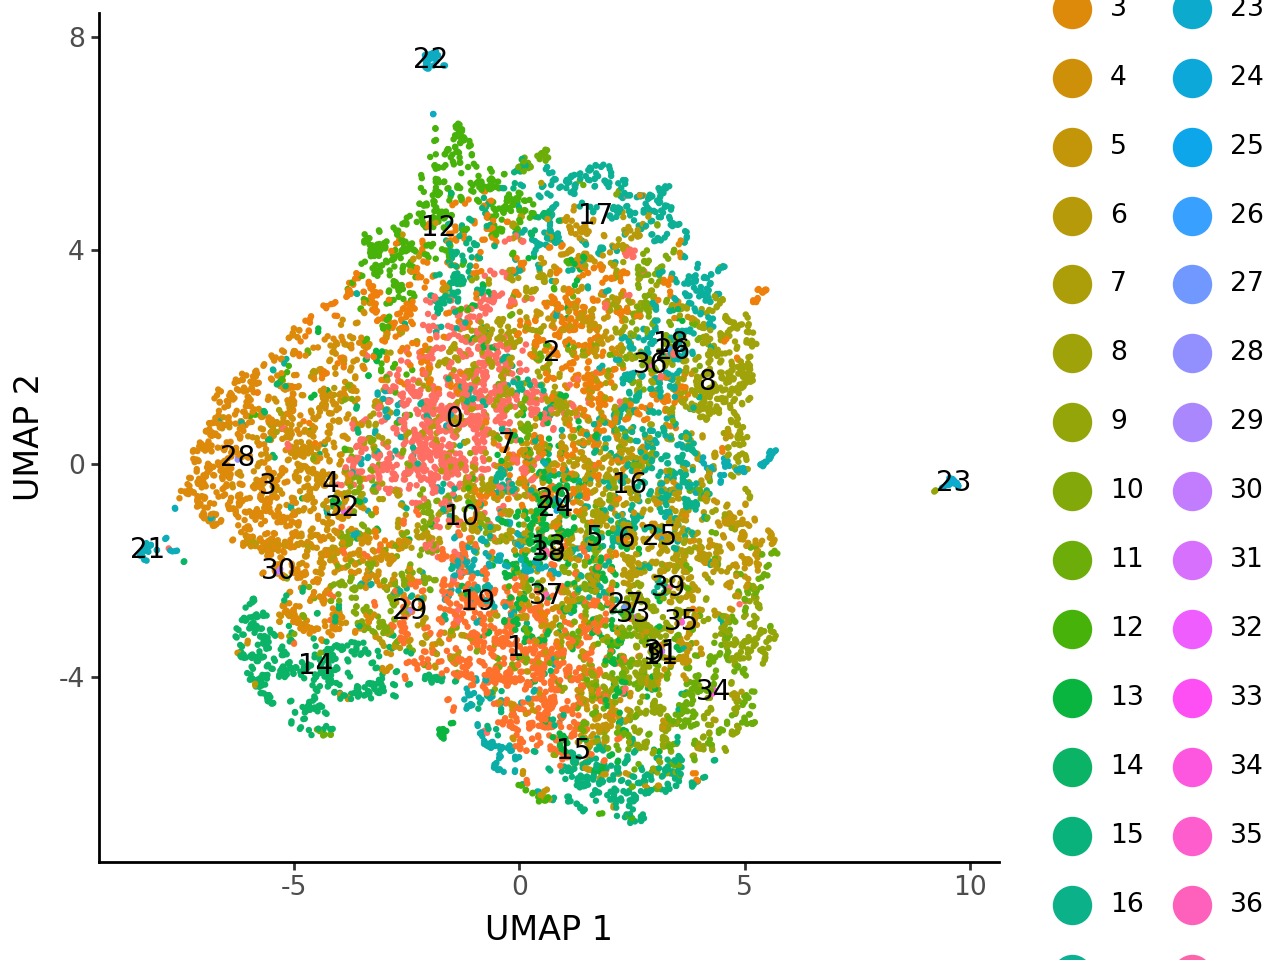

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [6]:
all_plots = pyliger.plot_by_dataset_and_cluster(ifnb_liger, axis_labels = ['UMAP 1', 'UMAP 2'], return_plots = True)
all_plots

#### Do not remove not expressed genes

100%|██████████| 30/30 [01:47<00:00,  3.57s/it]
/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/pyliger/plotting/_dataset_cluster.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


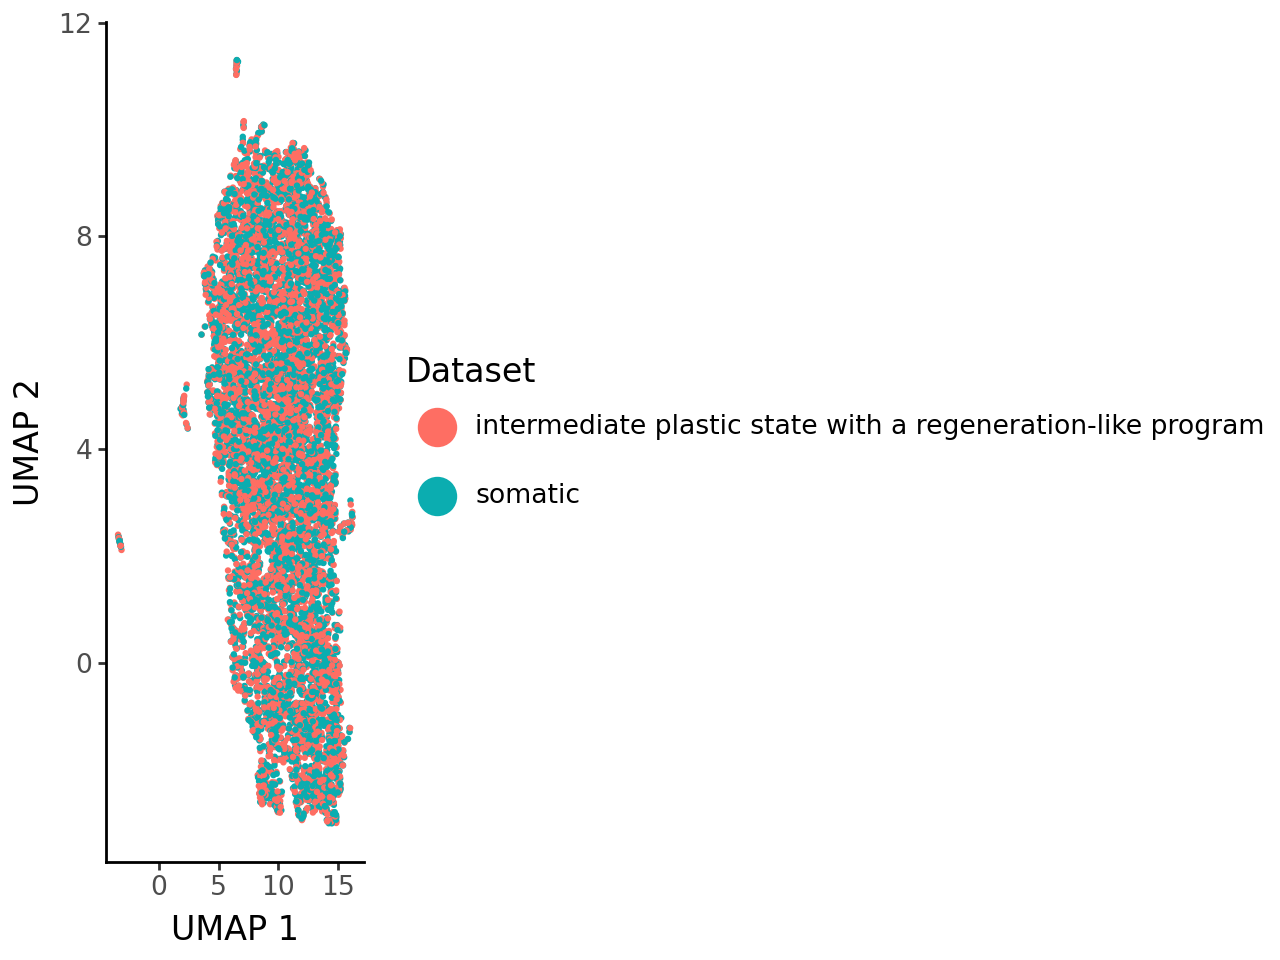

/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


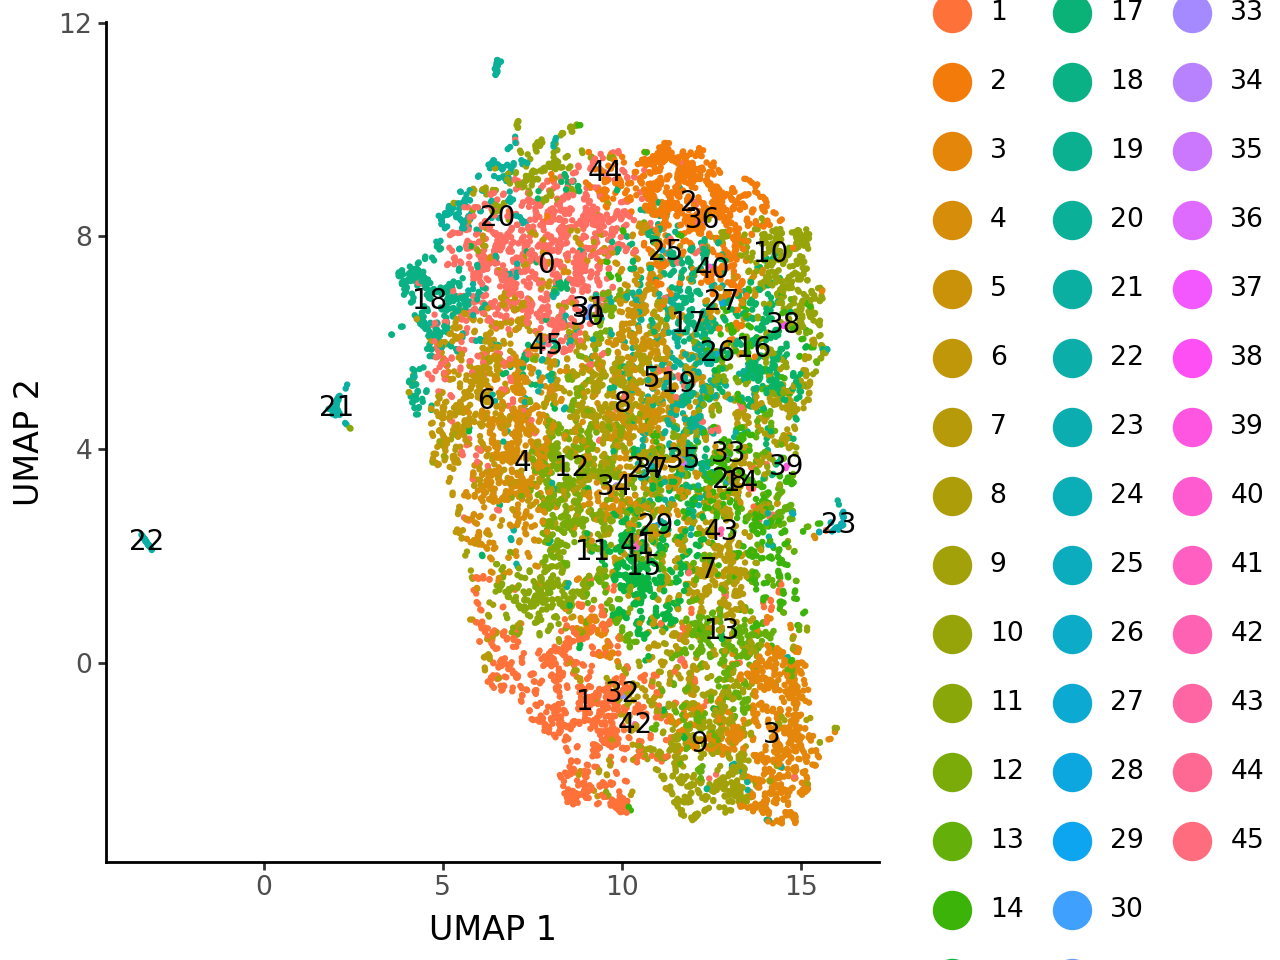

[<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>]

In [7]:
ifnb_liger_2 = pyliger.create_liger(adata_list,remove_missing=False)

# Preprocessing and Normalization
pyliger.normalize(ifnb_liger_2)
pyliger.select_genes(ifnb_liger_2)
pyliger.scale_not_center(ifnb_liger_2)

# Joint Matrix Factorization
# K es el número de matrices, análogo a PCA -> recomiendan entre 20-40, lo pongo como el PCA de Scanpy (50)
pyliger.optimize_ALS(ifnb_liger_2, k=50)

# Quantile Normalization and Joint Clustering
pyliger.quantile_norm(ifnb_liger_2, knn_k=20, quantiles =50, min_cells=20, max_sample=1000)
pyliger.louvain_cluster(ifnb_liger_2, resolution = 1)
# pyliger.leiden_cluster(ifnb_liger, resolution=0.25)

# Visualization and Downstream Analysis
pyliger.run_umap(ifnb_liger_2, distance = 'cosine', n_neighbors = 30, min_dist = 0.3)

all_plots_2 = pyliger.plot_by_dataset_and_cluster(ifnb_liger_2, axis_labels = ['UMAP 1', 'UMAP 2'], return_plots = True)
all_plots_2

### 1.1 Analysis

/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


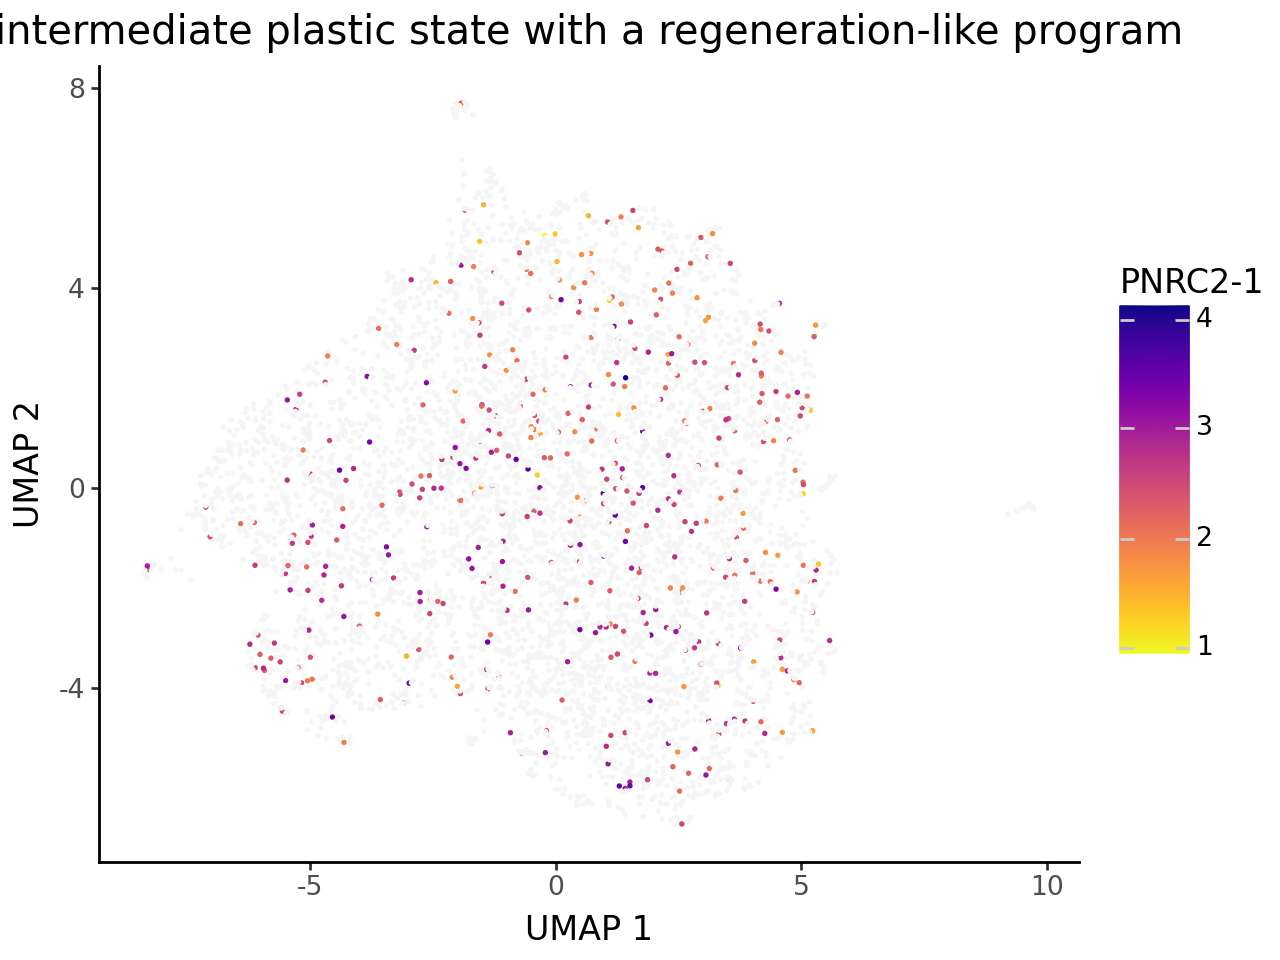

/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/IPython/lib/pretty.py:779: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


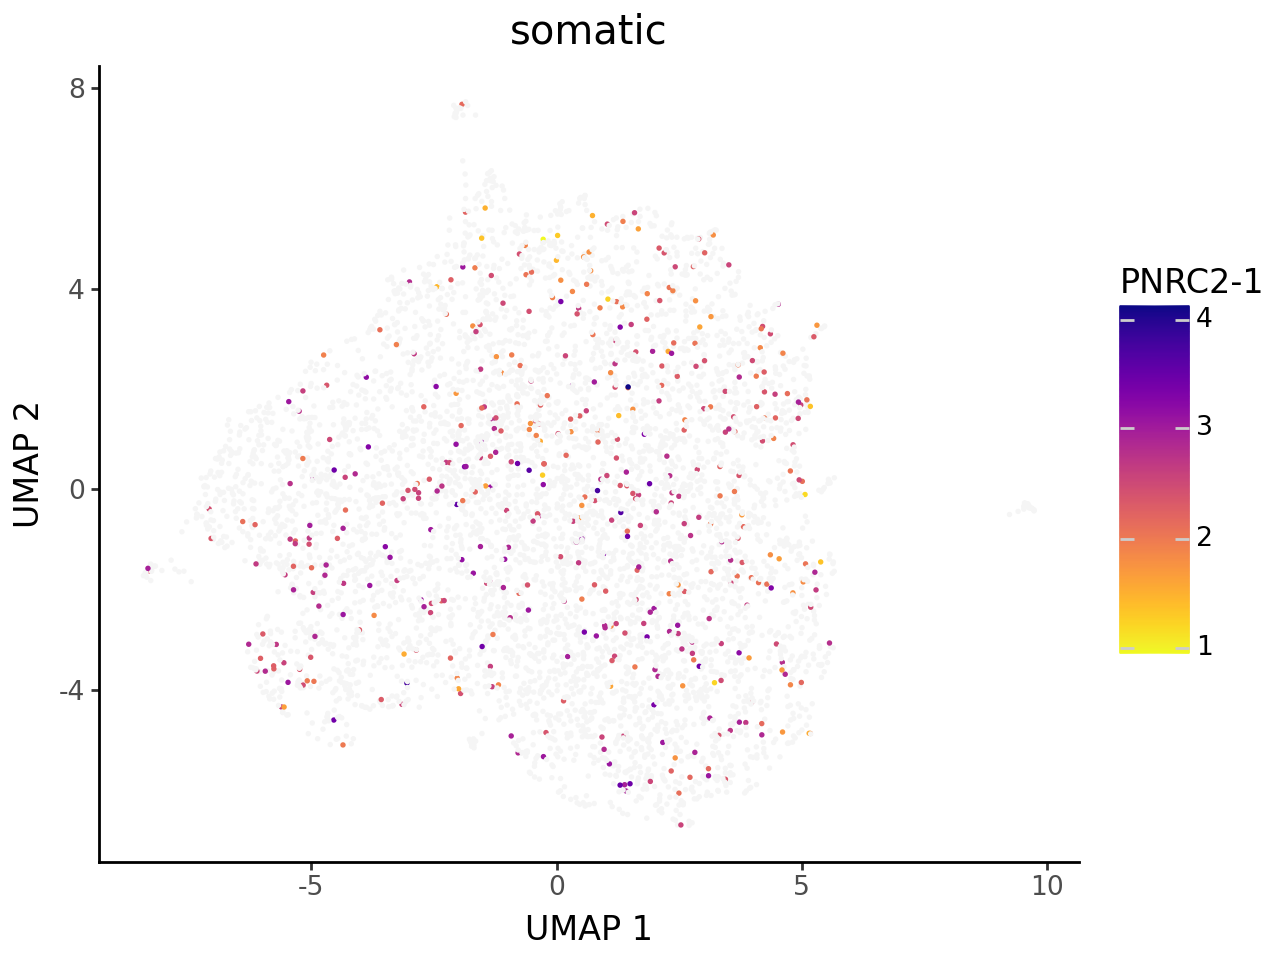

{'intermediate plastic state with a regeneration-like program': <Figure Size: (640 x 480)>,
 'somatic': <Figure Size: (640 x 480)>}

In [7]:
gene = pyliger.plot_gene(ifnb_liger, "PNRC2-1", axis_labels = ['UMAP 1', 'UMAP 2'], return_plots = True)
gene

In [33]:
# Using the run_wilcoxon function, we can next identify gene markers for all clusters
cluster_results = pyliger.run_wilcoxon(ifnb_liger, compare_method = "clusters")
cluster_results

Performing Wilcoxon test on ALL datasets: somatic, chemical_reprogramming


,feature,group,avgExpr,logFC,statistic,pval,padj
0,RP11-34P13.7,0.0,-22.915841,-0.002998,4644850.0,8.911154e-01,0.304207
1,RP11-34P13.8,0.0,-23.025851,-0.005159,4163386.0,4.213846e-08,1.000000
2,AL627309.1,0.0,-22.922757,0.031841,3973910.0,5.334457e-03,1.000000
3,AP006222.2,0.0,-17.887366,0.330065,3712920.0,8.267925e-01,0.437634
4,RP4-669L17.10,0.0,-22.972814,-0.013188,3507140.0,3.603594e-01,1.000000
...,...,...,...,...,...,...,...
866595,AL354822.1,39.0,-23.025851,-0.388079,10804.0,9.884866e-01,0.036076
866596,AL590523.1,39.0,-23.025851,-0.004731,10804.0,9.884866e-01,0.036076
866597,PNRC2-1,39.0,-23.025851,-1.039060,10804.0,9.884866e-01,0.036076
866598,SRSF10-1,39.0,-23.025851,-2.078365,10804.0,9.884866e-01,0.036076


In [39]:
cluster_results[cluster_results.group==22.0]

,feature,group,avgExpr,logFC,statistic,pval,padj
476630,RP11-34P13.7,22.0,-23.025851,-0.113123,10746.0,0.916544,0.261969
476631,RP11-34P13.8,22.0,-23.025851,-0.004725,10746.0,0.916544,0.261969
476632,AL627309.1,22.0,-23.025851,-0.074276,10746.0,0.916544,0.261969
476633,AP006222.2,22.0,-18.006040,0.183233,10746.0,0.916544,0.261969
476634,RP4-669L17.10,22.0,-23.025851,-0.065292,10746.0,0.916544,0.261969
...,...,...,...,...,...,...,...
498290,AL354822.1,22.0,-21.639976,1.001203,2355870.0,0.030580,1.000000
498291,AL590523.1,22.0,-23.025851,-0.004746,2442658.0,0.582819,1.000000
498292,PNRC2-1,22.0,-22.344873,-0.359086,2228070.0,0.003156,1.000000
498293,SRSF10-1,22.0,-18.777069,2.178056,2249308.0,0.059798,1.000000


In [ ]:
# TODO: usar estos clusters de genes para unirlo al atlas

### 1.2 Explore select genes as Highly Variable

In [8]:
HVG_LIGER_without_not_expressed_genes = list(ifnb_liger.var_genes)
print(f"Number of HVG selected by LIGER (deleting not expressed genes): {len(HVG_LIGER_without_not_expressed_genes)}")

HVG_LIGER_with_not_expressed_genes = list(ifnb_liger_2.var_genes)
print(f"Number of HVG selected by LIGER (without delete not expressed genes): {len(HVG_LIGER_with_not_expressed_genes)}")

HVG_Scanpy = list(HVG_data.var_names)
print(f"Number of HVG selected by Scanpy: {len(HVG_Scanpy)}")

Number of HVG selected by LIGER (deleting not expressed genes): 2972
Number of HVG selected by LIGER (without delete not expressed genes): 2890
Number of HVG selected by Scanpy: 919


In [9]:
common_HVG_genes_1 = list(set(HVG_LIGER_without_not_expressed_genes) & set(HVG_Scanpy))
print(f"There are {len(common_HVG_genes_1)} genes selected as HV by both tools (withou not expressed genes)")
common_HVG_genes_2 = list(set(HVG_LIGER_with_not_expressed_genes) & set(HVG_Scanpy))
print(f"There are {len(common_HVG_genes_2)} genes selected as HV by both tools (with noy expressed genes)")
common_HVG_genes_3 = list(set(HVG_LIGER_with_not_expressed_genes) & set(HVG_LIGER_without_not_expressed_genes))
print(f"There are {len(common_HVG_genes_3)} genes selected as HV by LIGER (with and without not expressed genes)")

There are 413 genes selected as HV by both tools (withou not expressed genes)
There are 413 genes selected as HV by both tools (with noy expressed genes)
There are 2890 genes selected as HV by LIGER (with and without not expressed genes)


In [11]:
# Save HVG
import pickle

with open('./data/HVG/LIGER_HVG_deleting_not_expressed_genes.pkl', 'wb') as file:
    pickle.dump(HVG_LIGER_without_not_expressed_genes, file)

with open('./data/HVG/LIGER_HVG_with_not_expressed_genes.pkl', 'wb') as file:
    pickle.dump(HVG_LIGER_with_not_expressed_genes, file)

with open('./data/HVG/SCANPY_HVG.pkl', 'wb') as file:
    pickle.dump(HVG_Scanpy, file)

# Same with and without deleting not expressed genes
with open('./data/HVG/common_HVG_LIGER_SCANPY.pkl', 'wb') as file:
    pickle.dump(common_HVG_genes_1, file)

# LOAD DATA -----------------
# with open('./data/HVG/LIGER_HVG_deleting_not_expressed_genes.pkl', 'rb') as file:
#     data = pickle.load(file)

### 1.3 Use preprocessed data by Scanpy

In [ ]:
# TODO: probar con los datos preprocesados previamente con Scanpy (HVG_data) -> integrated_data = liger.get_expression_matrix()

In [7]:
exp_1_name = "somatic"
exp_2_name = "chemical_reprogramming"

# One AnnData object/experiment
exp_1_data = create_anndata_by_experiment(HVG_data,exp_1_name)
exp_2_data = create_anndata_by_experiment(HVG_data,exp_1_name)

# Create "sample_name" (experiment) in uns 
exp_1_data.uns["sample_name"] = exp_1_name
exp_2_data.uns["sample_name"] = exp_2_name

# Check/create index name
exp_1_data = check_index_name(exp_1_data)
exp_2_data = check_index_name(exp_2_data)

# Check cells/genes names
check_cell_names(exp_1_data)
check_gene_names(exp_1_data)

check_cell_names(exp_2_data)
check_gene_names(exp_2_data)

/tmp/ipykernel_2532003/3406834250.py:9: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/tmp/ipykernel_2532003/3406834250.py:10: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [ ]:
HVG_data.obsm["Unintegrated"] = HVG_data.obsm["X_pca"]

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

In [8]:
# Create liger obj
adata_list = [exp_1_data,exp_2_data]
ifnb_liger_preprocessed = pyliger.create_liger(adata_list, remove_missing=False)

## If we want to delete not expressed genes
# expressed_genes_1_LIGER = list(ifnb_liger.adata_list[0].var_names)
# expressed_genes_1_data = exp_1_data[:, expressed_genes_1_LIGER]
# expressed_genes_2_LIGER = list(ifnb_liger.adata_list[1].var_names)
# expressed_genes_2_data = exp_2_data[:, expressed_genes_2_LIGER]
# adata_list_expressed = [expressed_genes_1_data,expressed_genes_2_data]
# ifnb_liger_preprocessed = pyliger.create_liger(adata_list_expressed)

# Create scale_data field -> dónde va realmente?
ifnb_liger_preprocessed.adata_list[0].layers["scale_data"] = sparse.csr_matrix(exp_1_data.X)
ifnb_liger_preprocessed.adata_list[1].layers["scale_data"] = sparse.csr_matrix(exp_2_data.X)

ifnb_liger_preprocessed.adata_list[0].layers["counts"] = sparse.csr_matrix(exp_1_data.X)
ifnb_liger_preprocessed.adata_list[1].layers["counts"] = sparse.csr_matrix(exp_2_data.X)

# Hack to make sure each method uses the same genes
HVG_Scanpy = list(HVG_data.var_names)
ifnb_liger_preprocessed.var_genes = HVG_Scanpy

# Joint Matrix Factorization
# K es el número de matrices, análogo a PCA -> recomiendan entre 20-40, lo pongo como el PCA de Scanpy
pyliger.optimize_ALS(ifnb_liger_preprocessed, k=50)

In [9]:
ifnb_liger_preprocessed.adata_list

[AnnData object with n_obs × n_vars = 5372 × 919
     obs: 'reprogramming_type', 'reprogramming_stage', 'cell_state', 'cell_type', 'cell_line', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'cell_state_encoded', 'n_genes', 'n_counts', 'predicted_doublet', 'doublet_score', 'empty_drops', 'nUMI', 'nGene', 'dataset'
     var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_sum', 'gene_sum_sq', 'nCell'
     uns: 'cell_state_colors', 'hvg', 'log1p', 'sample_name'
     layers: 'scale_data

In [13]:
HVG_data

AnnData object with n_obs × n_vars = 10101 × 919
    obs: 'reprogramming_type', 'reprogramming_stage', 'cell_state', 'cell_type', 'cell_line', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'cell_state_encoded', 'n_genes', 'n_counts', 'predicted_doublet', 'doublet_score', 'empty_drops'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_state_colors', 'hvg', 'log1p'

In [18]:

# Preprocessing and Normalization
# pyliger.normalize(ifnb_liger)
# pyliger.select_genes(ifnb_liger)
# pyliger.scale_not_center(ifnb_liger)
adata_list = [exp_1_data,exp_2_data]
liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
HVG_Scanpy = list(HVG_data.var_names)
liger_data.var_genes = HVG_Scanpy
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)


# Joint Matrix Factorization
# K es el número de matrices, análogo a PCA -> recomiendan entre 20-40, lo pongo como el PCA de Scanpy
pyliger.optimize_ALS(liger_data, k=50)

pyliger.quantile_norm(liger_data)


# Quantile Normalization and Joint Clustering
# pyliger.quantile_norm(ifnb_liger, knn_k=20, quantiles =50, min_cells=20, max_sample=1000)
# pyliger.louvain_cluster(ifnb_liger, resolution = 1)
# pyliger.leiden_cluster(ifnb_liger, resolution=0.25)

# Visualization and Downstream Analysis
# pyliger.run_umap(ifnb_liger, distance = 'cosine', n_neighbors = 30, min_dist = 0.3)

/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/pyliger/preprocessing/_scale.py:99: RuntimeWarning: divide by zero encountered in divide
/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/sklearn/utils/sparsefuncs.py:80: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 30/30 [00:00<00:00, 44.63it/s]


UnboundLocalError: cannot access local variable 'final_H' where it is not associated with a value